In [2]:
%load_ext autoreload
%autoreload 2
%cd ..

/net/tscratch/people/plghpiotr/cl-adaptation


In [3]:
import torch
from src.analysis import svd

torch.cuda.is_available()

False

In [4]:
from src.analysis import core


path = "results/2024/04.24/13-34-11/2/cifar100_fixed_lwf"
cfg = core.create_cfg(path)
cfg.data.num_workers = 1
data_factory = core.DataFactory(cfg)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from src.analysis.svd import (
    calculate_eigens_directclr,
    torch_calculate_eigens_directclr,
)


def plot_eigenspectrum_v2(name_path: dict, device="cpu"):
    columns = len(name_path)

    plt.rcParams.update({"font.size": 16})

    fig, axs = plt.subplots(1, columns, dpi=100, figsize=(columns * 5, 1 * 5))

    train_loader, _, test_loader, taskcla = data_factory[0]

    for col, (exp_name, exp_path) in enumerate(name_path.items()):
        cfg = core.create_cfg(exp_path)
        cfg.data.num_workers = 1
        model_factory = core.ModelFactory(cfg, exp_path, device=device)

        for task_idx, ckpt in enumerate(sorted(model_factory.ckpts)):
            model = model_factory.create_model(task=task_idx, num_classes=taskcla[1])
            outs = core.get_activations(model.model, test_loader, device=device)
            embeddings = torch.vstack(list(outs.values()))

            eigs = torch_calculate_eigens_directclr(embeddings)
            eigs = eigs.cpu().detach().numpy()
            df = pd.DataFrame()
            df["eigs"] = np.log(eigs / eigs[0])
            df["xs"] = list(range(len(eigs)))

            if len(name_path) > 1:
                ax = axs[col]
            else:
                ax = axs

            ax.plot(df["xs"].values, df["eigs"].values, label=f"Task {task_idx+1}")

        ax.legend(loc="upper right", fancybox=True, shadow=False)
        ax.set_title(exp_name)
        ax.set_ylim([-10, 0.5])
        ax.set_xlabel("Singular Value Rank Index")
        ax.grid()
        if col == 0:
            ax.set_ylabel("Log of normalized singular values")
        if col != 0:
            ax.set(ylabel="", yticklabels=[])

    fig.tight_layout()

In [6]:
from pathlib import Path

p = Path("models/cifar100_5/resnet34")
expname_path = {}
for dir in p.iterdir():
    for i in dir.iterdir():
        path = i.readlink()
        exp_name = "_".join(i.parts[2:])
        expname_path[exp_name] = path

In [7]:
expname_path

{'resnet34_finetuning_reg': PosixPath('results/2024/04.24/13-35-10/0/cifar100_fixed_finetuning'),
 'resnet34_finetuning_noreg': PosixPath('results/2024/04.17/18-13-25/0/cifar100_fixed_finetuning_final_checkpoint'),
 'resnet34_ewc_reg': PosixPath('results/2024/04.24/13-35-10/4/cifar100_fixed_ewc'),
 'resnet34_ewc_noreg': PosixPath('results/2024/04.22/23-58-39/0/cifar100_fixed_ewc_final_checkpoint'),
 'resnet34_lwf_reg': PosixPath('results/2024/04.24/13-34-11/2/cifar100_fixed_lwf'),
 'resnet34_lwf_noreg': PosixPath('results/2024/04.17/18-14-14/0/cifar100_fixed_lwf_final_checkpoint'),
 'resnet34_replay_reg': PosixPath('results/2024/04.24/13-35-10/2/cifar100_fixed_finetuning'),
 'resnet34_replay_noreg': PosixPath('results/2024/04.17/18-13-25/1/cifar100_fixed_finetuning_final_checkpoint')}

<All keys matched successfully>


  0%|          | 0/16 [00:00<?, ?it/s]


RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 37879808 bytes. Error code 12 (Cannot allocate memory)

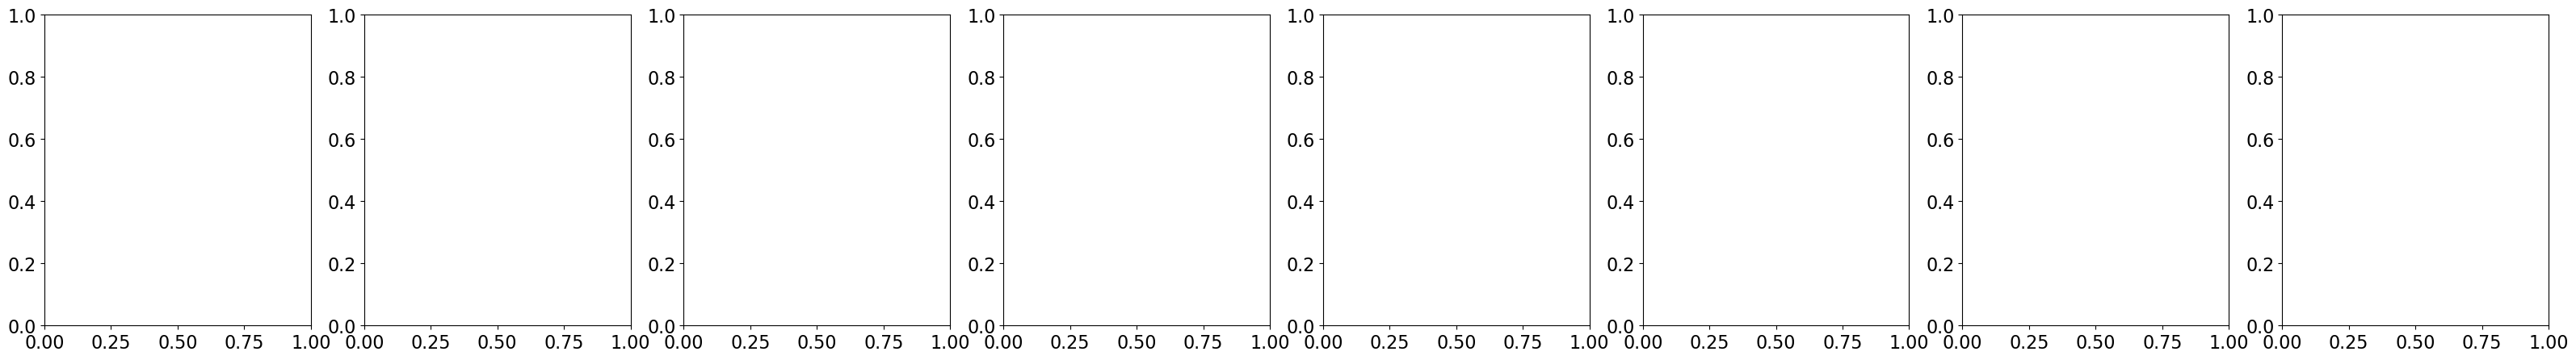

In [8]:
plot_eigenspectrum_v2(expname_path)